# Segmentation of Neighborhood, Jakarta.

The goal of this notebook is to provide data driven venue in Jakarta, Indonesia. The report should give an insight for traveler to understand the location on restaurant or any other activity in the area. Notebook contain several parts :
- Data Acquisition
- Cleanup
- Processing and visualization
- Segmentation and Clustering
- Conclusion

In [195]:
# Import Libraries
import pandas as pd
import os,sys
import urllib
import requests 
import io
import numpy as np
from urllib.request import urlopen
from bs4 import BeautifulSoup
!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library
from geopy.geocoders import Nominatim
from IPython.display import HTML
import base64
import seaborn as sns

print('Libraries imported.')

Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda/envs/DSX-Python35:
#
folium                    0.5.0                      py_0    conda-forge
Libraries imported.


In [2]:
def csv_to_df(urli):
    dataresult=pd.read_csv(io.StringIO(requests.get(urli).content.decode('utf-8')), error_bad_lines=False)
    return dataresult

In [4]:
jakarta_df_raw = csv_to_df("https://raw.githubusercontent.com/courseralab/ds-capstone/master/dataset/tbl_kodepos.csv")

In [5]:
print(jakarta_df_raw.shape)
jakarta_df_raw.head()

(81248, 6)


,id,kelurahan,kecamatan,kabupaten,provinsi,kodepos
0,1,GAMBIR,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10110
1,2,KEBON KELAPA,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10120
2,3,PETOJO UTARA,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10130
3,4,DURI PULO,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10140
4,5,CIDENG,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10150


In [6]:
#filter dataset with Jakarta province only
jakarta_df1=jakarta_df_raw.loc[jakarta_df_raw['provinsi'] == 'DKI JAKARTA']

In [7]:
print(jakarta_df1.shape)
jakarta_df1.head()

(267, 6)


,id,kelurahan,kecamatan,kabupaten,provinsi,kodepos
0,1,GAMBIR,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10110
1,2,KEBON KELAPA,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10120
2,3,PETOJO UTARA,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10130
3,4,DURI PULO,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10140
4,5,CIDENG,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10150


In [8]:
#Rename Columns to English
jakarta_df1.rename(columns={'provinsi': 'Province'}, inplace=True)
jakarta_df1.rename(columns={'kabupaten': 'Regency'}, inplace=True)
jakarta_df1.rename(columns={'kecamatan': 'District'}, inplace=True)
jakarta_df1.rename(columns={'kelurahan': 'Subdistricts'}, inplace=True)
jakarta_df1.rename(columns={'kodepos': 'PostalCode'}, inplace=True)

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [9]:
print(jakarta_df1.shape)
jakarta_df1.head()

(267, 6)


,id,Subdistricts,District,Regency,Province,PostalCode
0,1,GAMBIR,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10110
1,2,KEBON KELAPA,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10120
2,3,PETOJO UTARA,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10130
3,4,DURI PULO,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10140
4,5,CIDENG,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10150


In [10]:
# Save file to CSV function.
def file_to_save( dataframe, fname = "CSV Files Available", csvfile = "dataframe.csv"):  
    csv = dataframe.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    filelink = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    htmlfile = filelink.format(payload=payload,title=fname,filename=csvfile)
    return HTML(htmlfile)

In [11]:
# Save Jakarta dataframe for future use
file = "Jakarta_postal_code.csv"
link = "Storage:Jakarta_postal_code.csv"
file_to_save(jakarta_df1,file,link)


In [12]:
# Filter needed columns only
jakarta_df2=jakarta_df1.filter(['Subdistricts','District','Regency', 'Province','PostalCode'], axis=1)

In [13]:
print(jakarta_df2.shape)
jakarta_df2.head()

(267, 5)


,Subdistricts,District,Regency,Province,PostalCode
0,GAMBIR,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10110
1,KEBON KELAPA,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10120
2,PETOJO UTARA,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10130
3,DURI PULO,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10140
4,CIDENG,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10150


In [14]:
# Get Coordinate for each zip code using geolocator API coordinate
import time
geolocator = Nominatim()
jakarta_df3=jakarta_df2
idx=-1
for kelurahan, kecamatan, kabupaten, zipcode in zip(jakarta_df2['Subdistricts'],jakarta_df2['District'], \
                                                    jakarta_df2['Regency'], jakarta_df2['PostalCode'] ):
    idx= idx+1
    #alamat = kelurahan + ", " + "Jakarta, Indonesia"
    alamat = str(zipcode) + " " + "Jakarta, Indonesia"
    try :
        location = geolocator.geocode(alamat)
        rowIndex = jakarta_df3.index[idx]
        print(rowIndex)
        print(alamat)
        print("====>", location)
        print("====>",(location.latitude, location.longitude))
        jakarta_df3.loc[rowIndex, 'Latitude'] = location.latitude
        jakarta_df3.loc[rowIndex, 'Longitude'] = location.longitude
        jakarta_df3.loc[rowIndex, 'Note'] = alamat
        time.sleep(1) # Delay every seconds 
    except:
        continue  


0
10110 Jakarta, Indonesia
====> RW 02, JKT, 10110, Indonesia
====> (-6.17581116679651, 106.826905664396)
1
10120 Jakarta, Indonesia
====> RW 02, JKT, 10120, Indonesia
====> (-6.16206477977513, 106.826741383746)
2
10130 Jakarta, Indonesia
====> RW 08, JKT, 10130, Indonesia
====> (-6.16488195810053, 106.818566007249)
3
10140 Jakarta, Indonesia
====> RW 01, JKT, 10140, Indonesia
====> (-6.1651961, 106.8102152)
4
10150 Jakarta, Indonesia
====> RW 05, JKT, 10150, Indonesia
====> (-6.16740539340644, 106.812690493727)
5
10160 Jakarta, Indonesia
====> RW 03, JKT, 10160, Indonesia
====> (-6.17571843553567, 106.817905617335)
6
10210 Jakarta, Indonesia
====> RW 03, Bendungan Hilir, Tanah Abang, JKT, 10210, Indonesia
====> (-6.2116445, 106.8116372)
7
10220 Jakarta, Indonesia
====> RT 13, JKT, 10220, Indonesia
====> (-6.20911508786607, 106.818156747136)
8
10230 Jakarta, Indonesia
====> RW 12, JKT, 10230, Indonesia
====> (-6.19285524074269, 106.812846050231)
9
10240 Jakarta, Indonesia
====> RW 03, 

In [15]:
print(jakarta_df3.shape)
jakarta_df3.head()

(267, 8)


,Subdistricts,District,Regency,Province,PostalCode,Latitude,Longitude,Note
0,GAMBIR,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10110,-6.175811,106.826906,"10110 Jakarta, Indonesia"
1,KEBON KELAPA,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10120,-6.162065,106.826741,"10120 Jakarta, Indonesia"
2,PETOJO UTARA,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10130,-6.164882,106.818566,"10130 Jakarta, Indonesia"
3,DURI PULO,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10140,-6.165196,106.810215,"10140 Jakarta, Indonesia"
4,CIDENG,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10150,-6.167405,106.812690,"10150 Jakarta, Indonesia"


In [16]:
jakarta_df4=jakarta_df3.filter(['Subdistricts','District','Regency', 'Province','PostalCode','Latitude','Longitude'], axis=1)

In [17]:
print(jakarta_df4.shape)
jakarta_df4.head()

(267, 7)


,Subdistricts,District,Regency,Province,PostalCode,Latitude,Longitude
0,GAMBIR,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10110,-6.175811,106.826906
1,KEBON KELAPA,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10120,-6.162065,106.826741
2,PETOJO UTARA,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10130,-6.164882,106.818566
3,DURI PULO,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10140,-6.165196,106.810215
4,CIDENG,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10150,-6.167405,106.812690


In [18]:
# Save Jakarta dataframe for future use
file = "Jakarta_postal_code_with_coordinate.csv"
link = "Storage:Jakarta_postal_code_with_coordinate.csv"
file_to_save(jakarta_df4,file,link)

#### Find Null value in dataframe

Dataframe check for any null value. Do neccessary step to clean up.

In [19]:
jakarta_df4.isnull().sum()

Subdistricts    0
District        0
Regency         0
Province        0
PostalCode      0
Latitude        0
Longitude       0
dtype: int64

Cleaned null from dataframe

In [20]:
jakarta_df5=jakarta_df4
jakarta_df5.dropna(subset=['Latitude'], how='any', inplace = True)

In [21]:
print(jakarta_df5.shape)
jakarta_df5.head()

# Save Jakarta dataframe for future use
file = "Jakarta_postal_code_with_coordinate_cleaned.csv"
link = "Storage:Jakarta_postal_code_with_coordinate_cleaned.csv"
file_to_save(jakarta_df5,file,link)


(267, 7)


#### Visualized Dataframe in map

In [22]:
# Get jakarta coordinate
location = geolocator.geocode("Jakarta Indonesia")
latitude=location.latitude
longitude=location.longitude
print("====>", location)
print("====>",(location.latitude, location.longitude))


====> JKT, Indonesia
====> (-6.1753942, 106.827183)


In [23]:
# create map of Jakarta using latitude and longitude values above
jakarta_map = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood, postalcode in zip(jakarta_df5['Latitude'], jakarta_df5['Longitude'],  jakarta_df5['Subdistricts'], jakarta_df5['PostalCode']):
    label = '{},{}'.format(neighborhood,postalcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(jakarta_map)
jakarta_map

In [199]:
# This is Froursquare Credential

CLIENT_ID = 'hidden' # your Foursquare ID
CLIENT_SECRET = 'hidden' # your Foursquare Secret

VERSION = '20180605' # Foursquare API version
LIMIT = 500
radius=500

In [25]:
# Get list of venue on 500 meter radius, limit by limit value
# Get venue function.
def getVenueList(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format( \
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # insert result into dataframe
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['id'],
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['id'],
            v['venue']['categories'][0]['name']) for v in results])

    neigh_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    neigh_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'VenueID',     
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue CatID', 
                  'Venue Category']
    
    return(neigh_venues)


In [26]:
# Get Jakarta Venue using API
jakarta_venuelist= getVenueList(names=jakarta_df5['Subdistricts'],
                                   latitudes=jakarta_df5['Latitude'],
                                   longitudes=jakarta_df5['Longitude']
                                  )


GAMBIR
KEBON KELAPA
PETOJO UTARA
DURI PULO
CIDENG
PETOJO SELATAN
BENDUNGAN HILIR
KARET TENGSIN
KEBON MELATI
KEBON KACANG
KAMPUNG BALI
PETAMBURAN
GELORA
MENTENG
PEGANGSAAN
CIKINI
KEBON SIRIH
GONDANGDIA
SENEN
KWITANG
KENARI
PASEBAN
KRAMAT
BUNGUR
CEMPAKA PUTIH TIMUR
CEMPAKA PUTIH BARAT
GALUR
TANAH TINGGI
KAMPUNG RAWA
JOHAR BARU
RAWASARI
GUNUNG SAHARI SELATAN
KEMAYORAN
KEBON KOSONG
CEMPAKA BARU
HARAPAN MULYA
SUMUR BATU
SERDANG
UTAN PANJANG
PASAR BARU
GUNUNG SAHARI UTARA
MANGGA DUA SELATAN
KARANG ANYAR
KARTINI
PINANGSIA
GLODOK
KEAGUNGAN
KRUKUT
TAMAN SARI
MAPHAR
TANGKI
MANGGA BESAR
TANAH SEREAL
TAMBORA
ROA MALAKA
PEKOJAN
JEMBATAN LIMA
KRENDANG
DURI SELATAN
DURI UTARA
KALI ANYAR
JEMBATAN BESI
ANGKE
SLIPI
KOTA BAMBU SELATAN
KOTA BAMBU UTARA
JATIPULO
TOMANG
GROGOL
JELAMBAR
JELAMBAR BARU
WIJAYA KUSUMA
TANJUNG DUREN SELATAN
TANJUNG DUREN UTARA
KEMANGGISAN
PALMERAH
DURI KEPA
KEDOYA SELATAN
KEDOYA UTARA
KEBON JERUK
SUKABUMI UTARA (ILIR)
KELAPA DUA
SUKABUMI SELATAN (UDIK)
KEMBANGAN SELATAN
KEMBANGAN

In [27]:
print(jakarta_venuelist.shape)
jakarta_venuelist.head()

(4286, 9)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,VenueID,Venue,Venue Latitude,Venue Longitude,Venue CatID,Venue Category
0,GAMBIR,-6.175811,106.826906,4e8a3ffbd3e3304c8afca029,National Monument Park,-6.175331,106.827047,4bf58dd8d48988d163941735,Park
1,GAMBIR,-6.175811,106.826906,4fa487c2e4b0244336041fe7,Jogging Track MONAS,-6.175537,106.827134,4bf58dd8d48988d106941735,Track
2,GAMBIR,-6.175811,106.826906,4b84944df964a520ac3c31e3,Museum Nasional Indonesia,-6.176353,106.822830,4bf58dd8d48988d181941735,Museum
3,GAMBIR,-6.175811,106.826906,4ed1a2a1f5b9832adbbcff90,Lapangan Silang Monas,-6.177649,106.826851,4bf58dd8d48988d164941735,Plaza
4,GAMBIR,-6.175811,106.826906,4c68df8fd7509c74b7cffaa2,Taman Merah Putih,-6.175397,106.827165,4bf58dd8d48988d167941735,Skate Park


In [28]:
# Get venue score from list of Jakarta venue list above.
def getVenuescore(dataframe,start,stop):
    newdf=dataframe.iloc[start:stop+1]
    idx=-1;
    for VenueID, VenueName in zip(dataframe['VenueID'], dataframe['Venue']):
        idx=idx+1
        if start <= idx <= stop:
            printVenue = str(idx) + ", " + VenueID + ", " + VenueName
            #print(printVenue)

            url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(VenueID,\
                        CLIENT_ID,CLIENT_SECRET,VERSION)
            venScore = 0.00 # initialize Venue Score to zero

            # Process results
            try:
                result = requests.get(url).json()
                venScore  = result['response']['venue']['rating']
            except: 
                pass
            newdf.loc[dataframe.index[idx], 'Venue Score'] = venScore
            printvenueandscore = printVenue + ", " + str(venScore)
            print(printvenueandscore )
        else:
            continue
    return(newdf)


Due to limitation of free version of Foursquare. Rating data collected maximum 500 perday only. Result of previous day save on this location https://github.com/courseralab/ds-capstone/tree/master/dataset

In [31]:
# Get Jakarta Venue Score using Foursquare API

jakarta_venue_score04 = getVenuescore(jakarta_venuelist,1500,1999)
jakarta_venue_score04.head()
# Save dataframe for future use
jakarta_venue_score04.to_csv('jakarta_venue_score04.csv')

# Save Jakarta dataframe for future use
file = "jakarta_venue_score04.csv"
link = "Storage:jakarta_venue_score04.csv"
file_to_save(jakarta_venue_score04,file,link)

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


1500, 4bcb26ec0687ef3bb212ddcc, PHD, 0.0
1501, 5843ae075a58693fa1abe538, Domino's Pizza, 0.0
1502, 4e4bc88e7d8b6016b18c867b, Bakmi Ratu Dahlia, 0.0
1503, 508cf982e4b09898c825e784, Hawker Kopitiam, 0.0
1504, 4b5ea89bf964a5202e9529e3, McDonald's, 0.0
1505, 4d5be4e1e7f754815c501497, Nasi Goreng Gila, 0.0
1506, 51b0324a498ecd61edb07953, MOR, 0.0
1507, 4d97221d97d06ea8b55e130b, Gandy Steak House, 0.0
1508, 4d3d52aa8edf3704fe7cb8a5, Inul Vizta, 0.0
1509, 4fff3fcde4b03461217c0a0d, Indomaret, 0.0
1510, 510cf341e4b0faae2f9ccea4, Raizo Sushi Bar & Rooftop, 0.0
1511, 4cd37ae0d160b1f7db5124ab, Apotik Taman Cosmos, 0.0
1512, 4c26cedbf1272d7f405587c5, Rumah Makan Padang Jaya, 0.0
1513, 4c69dadf3bad2d7f9c11b1ee, Nasi Tim Pasar Pagi Muara Karang, 0.0
1514, 4bc33604920eb71358151d2c, Nasi goreng PDI, 0.0
1515, 4d04443426adb1f77eb3d170, Bakmi Asoei, 0.0
1516, 4bbe1874f57ba5934eedaeb9, Bubur Bun Ong, 0.0
1517, 53536785498ea0a1b83292a6, AYAM PRESTO Ny.Nita, 0.0
1518, 4e19452662e12640d87e1342, Bakmi Permata

In [48]:
#Retrieved data from github
jakarta_venue_score01 = csv_to_df("https://raw.githubusercontent.com/courseralab/ds-capstone/master/dataset/Storage_jakarta_venue_score01.csv")
jakarta_venue_score02 = csv_to_df("https://raw.githubusercontent.com/courseralab/ds-capstone/master/dataset/Storage_jakarta_venue_score02.csv")
jakarta_venue_score03 = csv_to_df("https://raw.githubusercontent.com/courseralab/ds-capstone/master/dataset/Storage_jakarta_venue_score03.csv")

In [49]:
jakarta_venue_score01.head()

,Unnamed: 0,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,VenueID,Venue,Venue Latitude,Venue Longitude,Venue CatID,Venue Category,Venue Score
0,0,GAMBIR,-6.175811,106.826906,4e8a3ffbd3e3304c8afca029,National Monument Park,-6.175331,106.827047,4bf58dd8d48988d163941735,Park,7.4
1,1,GAMBIR,-6.175811,106.826906,4fa487c2e4b0244336041fe7,Jogging Track MONAS,-6.175537,106.827134,4bf58dd8d48988d106941735,Track,7.3
2,2,GAMBIR,-6.175811,106.826906,4b84944df964a520ac3c31e3,Museum Nasional Indonesia,-6.176353,106.822830,4bf58dd8d48988d181941735,Museum,8.3
3,3,GAMBIR,-6.175811,106.826906,4ed1a2a1f5b9832adbbcff90,Lapangan Silang Monas,-6.177649,106.826851,4bf58dd8d48988d164941735,Plaza,7.1
4,4,GAMBIR,-6.175811,106.826906,4c68df8fd7509c74b7cffaa2,Taman Merah Putih,-6.175397,106.827165,4bf58dd8d48988d167941735,Skate Park,6.9


In [50]:
jakarta_venue_score02.head()

,Unnamed: 0,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,VenueID,Venue,Venue Latitude,Venue Longitude,Venue CatID,Venue Category,Venue Score
0,500,PEGANGSAAN,-6.196905,106.841957,4bffc9ccb09e9c74e9f8d786,Sate Padang Murni,-6.196372,106.840277,4bf58dd8d48988d1cb941735,Food Truck,6.2
1,501,PEGANGSAAN,-6.196905,106.841957,4bf7df924a67c928d84324cf,Ayam Bakar Khas Solo - Megaria,-6.199837,106.843636,4deefc054765f83613cdba6f,Indonesian Restaurant,6.5
2,502,PEGANGSAAN,-6.196905,106.841957,4c70e12b9a669c74d89ce0bd,Pasar Antik & Koper Jalan Surabaya,-6.198978,106.839746,4bf58dd8d48988d116951735,Antique Shop,6.4
3,503,PEGANGSAAN,-6.196905,106.841957,4ba5efcdf964a520332a39e3,Stasiun Cikini,-6.198710,106.841322,4bf58dd8d48988d129951735,Train Station,6.2
4,504,PEGANGSAAN,-6.196905,106.841957,4bcbf24fcc8cd13a4f48c0cf,Bumbu Desa,-6.194711,106.839384,52960eda3cf9994f4e043ac6,Sundanese Restaurant,6.4


In [51]:
jakarta_venue_score03.head()

,Unnamed: 0,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,VenueID,Venue,Venue Latitude,Venue Longitude,Venue CatID,Venue Category,Venue Score
0,1000,PINANGSIA,-6.135876,106.813455,4e16607881dcdf54e7f860c5,A&W,-6.137909,106.814768,4bf58dd8d48988d16e941735,Fast Food Restaurant,5.6
1,1001,PINANGSIA,-6.135876,106.813455,4ba6f3ddf964a520907939e3,Toshiba Service Center,-6.133729,106.809801,4bf58dd8d48988d122951735,Electronics Store,0.0
2,1002,GLODOK,-6.144714,106.811673,4dfc3866227185f38b943c19,Bakmie Loncat ba*lont,-6.143433,106.813160,4bf58dd8d48988d1d1941735,Noodle House,7.9
3,1003,GLODOK,-6.144714,106.811673,4d46b2121ed56dcb8726c854,Bakmi Aheng Kemurniaan,-6.145610,106.812675,4bf58dd8d48988d145941735,Chinese Restaurant,7.6
4,1004,GLODOK,-6.144714,106.811673,56d11a02498ea69d398cf648,Pantjoran Tea House,-6.142463,106.814692,4bf58dd8d48988d1dc931735,Tea Room,8.6


In [126]:
frames = [jakarta_venue_score01, jakarta_venue_score02, jakarta_venue_score03]
jakarta_venue_score_all=pd.concat(frames)

In [127]:
print(jakarta_venue_score_all.shape)
jakarta_venue_score_all.head()

(1501, 11)


,Unnamed: 0,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,VenueID,Venue,Venue Latitude,Venue Longitude,Venue CatID,Venue Category,Venue Score
0,0,GAMBIR,-6.175811,106.826906,4e8a3ffbd3e3304c8afca029,National Monument Park,-6.175331,106.827047,4bf58dd8d48988d163941735,Park,7.4
1,1,GAMBIR,-6.175811,106.826906,4fa487c2e4b0244336041fe7,Jogging Track MONAS,-6.175537,106.827134,4bf58dd8d48988d106941735,Track,7.3
2,2,GAMBIR,-6.175811,106.826906,4b84944df964a520ac3c31e3,Museum Nasional Indonesia,-6.176353,106.822830,4bf58dd8d48988d181941735,Museum,8.3
3,3,GAMBIR,-6.175811,106.826906,4ed1a2a1f5b9832adbbcff90,Lapangan Silang Monas,-6.177649,106.826851,4bf58dd8d48988d164941735,Plaza,7.1
4,4,GAMBIR,-6.175811,106.826906,4c68df8fd7509c74b7cffaa2,Taman Merah Putih,-6.175397,106.827165,4bf58dd8d48988d167941735,Skate Park,6.9


In [128]:
jakarta_venue_score=jakarta_venue_score_all.loc[jakarta_venue_score_all['Venue Score'] >0.0]
print(jakarta_venue_score.shape)
jakarta_venue_score.head()

(1417, 11)


,Unnamed: 0,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,VenueID,Venue,Venue Latitude,Venue Longitude,Venue CatID,Venue Category,Venue Score
0,0,GAMBIR,-6.175811,106.826906,4e8a3ffbd3e3304c8afca029,National Monument Park,-6.175331,106.827047,4bf58dd8d48988d163941735,Park,7.4
1,1,GAMBIR,-6.175811,106.826906,4fa487c2e4b0244336041fe7,Jogging Track MONAS,-6.175537,106.827134,4bf58dd8d48988d106941735,Track,7.3
2,2,GAMBIR,-6.175811,106.826906,4b84944df964a520ac3c31e3,Museum Nasional Indonesia,-6.176353,106.822830,4bf58dd8d48988d181941735,Museum,8.3
3,3,GAMBIR,-6.175811,106.826906,4ed1a2a1f5b9832adbbcff90,Lapangan Silang Monas,-6.177649,106.826851,4bf58dd8d48988d164941735,Plaza,7.1
4,4,GAMBIR,-6.175811,106.826906,4c68df8fd7509c74b7cffaa2,Taman Merah Putih,-6.175397,106.827165,4bf58dd8d48988d167941735,Skate Park,6.9


Copy To New Dataframe

In [129]:
jakarta_venue=jakarta_venue_score

In [131]:
# Print Jakarta Venue Dataframe
print(jakarta_venue.shape)
jakarta_venue.head()

# Save dataframe for future use
jakarta_venue.to_csv('jakarta_venue.csv')

# Save Jakarta dataframe for future use
file = "Jakarta_venue_postal_code_with_coordinate.csv"
link = "Storage:Jakarta_venue_postal_code_with_coordinate.csv"
file_to_save(jakarta_venue,file,link)


(1417, 11)


In [134]:
#Check point for Future use. Read from local saved csv file.
jakarta_venue1 = pd.read_csv('jakarta_venue.csv')

In [135]:
print(jakarta_venue.shape)
jakarta_venue1.head()

(1417, 11)


,Unnamed: 0,Unnamed: 0.1,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,VenueID,Venue,Venue Latitude,Venue Longitude,Venue CatID,Venue Category,Venue Score
0,0,0,GAMBIR,-6.175811,106.826906,4e8a3ffbd3e3304c8afca029,National Monument Park,-6.175331,106.827047,4bf58dd8d48988d163941735,Park,7.4
1,1,1,GAMBIR,-6.175811,106.826906,4fa487c2e4b0244336041fe7,Jogging Track MONAS,-6.175537,106.827134,4bf58dd8d48988d106941735,Track,7.3
2,2,2,GAMBIR,-6.175811,106.826906,4b84944df964a520ac3c31e3,Museum Nasional Indonesia,-6.176353,106.822830,4bf58dd8d48988d181941735,Museum,8.3
3,3,3,GAMBIR,-6.175811,106.826906,4ed1a2a1f5b9832adbbcff90,Lapangan Silang Monas,-6.177649,106.826851,4bf58dd8d48988d164941735,Plaza,7.1
4,4,4,GAMBIR,-6.175811,106.826906,4c68df8fd7509c74b7cffaa2,Taman Merah Putih,-6.175397,106.827165,4bf58dd8d48988d167941735,Skate Park,6.9


In [136]:
jakarta_venue1['Venue Category'].value_counts()

Chinese Restaurant             109
Indonesian Restaurant           94
Noodle House                    93
Hotel                           72
Coffee Shop                     67
Asian Restaurant                57
Food Truck                      45
Café                            42
Convenience Store               41
Japanese Restaurant             37
Fast Food Restaurant            33
Restaurant                      31
Bakery                          30
Pizza Place                     27
Donut Shop                      21
Shopping Mall                   18
Seafood Restaurant              18
Indonesian Meatball Place       17
Steakhouse                      16
Soup Place                      16
Department Store                15
Dessert Shop                    13
Hotel Bar                       13
Food Court                      12
Train Station                   11
Snack Place                     11
Resort                          11
Karaoke Bar                     11
Nightclub           

In [137]:
jakarta_venue_filter1=jakarta_venue1
jakarta_venue_filter1.rename(columns={'Venue Category': 'Venue_Category'}, inplace=True)

In [138]:
# Filter dataframe to food category only
list_of_values = ['Indonesian Restaurant','Coffee Shop','Chinese Restaurant',\
                 'Noodle House','Asian Restaurant','Fast Food Restaurant',\
                 'Food Truck','Café','Bakery','Restaurant','Japanese Restaurant',\
                 'Pizza Place','Seafood Restaurant','Food Court','Steakhouse',\
                 'Donut Shop','Dessert Shop','Soup Place','Indonesian Meatball Place',\
                 'Candy Store','Snack Place','amen Restaurant','Bistro','Dim Sum Restaurant',\
                 'Sushi Restaurant','Fried Chicken Joint','BBQ Joint','Wine Bar',\
                 'Italian Restaurant','Korean Restaurant','Bed & Breakfast','Betawinese Restaurant',\
                 'Middle Eastern Restaurant','Vietnamese Restaurant','Hookah Bar',\
                 'Deli / Bodega','American Restaurant','German Restaurant',\
                 'Malay Restaurant','Beer Garden','Acehnese Restaurant','Cafeteria',\
                 'Cupcake Shop','Indian Restaurant','Cantonese Restaurant','Vegetarian / Vegan Restaurant'\
                 'Sandwich Place','Salad Place','Dumpling Restaurant']

jakarta_venue_filter2=jakarta_venue_filter1[jakarta_venue_filter1.Venue_Category.apply(lambda x: np.intersect1d(x, list_of_values).size > 0)]

In [139]:
jakarta_venue_filter2.head()

,Unnamed: 0,Unnamed: 0.1,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,VenueID,Venue,Venue Latitude,Venue Longitude,Venue CatID,Venue_Category,Venue Score
5,5,5,GAMBIR,-6.175811,106.826906,51047707e4b0059ce06c2cf0,Starbucks,-6.177147,106.830818,4bf58dd8d48988d1e0931735,Coffee Shop,7.3
8,8,8,GAMBIR,-6.175811,106.826906,4e16b2f1b0fb42f98734fc9d,Sate Senayan,-6.176699,106.829012,4deefc054765f83613cdba6f,Indonesian Restaurant,6.5
9,9,9,GAMBIR,-6.175811,106.826906,55991939498e83c3be4c3731,Bakmi GM,-6.177536,106.831017,4bf58dd8d48988d1d1941735,Noodle House,6.9
10,10,10,GAMBIR,-6.175811,106.826906,4be6da09910020a110add414,Ropita Aneka Rasa,-6.177792,106.830954,4bf58dd8d48988d1cb941735,Food Truck,6.6
12,12,12,GAMBIR,-6.175811,106.826906,56c72378cd1080d7a15257d6,McDonald’s,-6.177294,106.830890,4bf58dd8d48988d16e941735,Fast Food Restaurant,6.4


In [140]:
# Remove rows without reviews
jakarta_venue_filter2=jakarta_venue_filter2.loc[jakarta_venue1['Venue Score'] >0.0]
print(jakarta_venue_filter2.shape)
jakarta_venue_filter2.head()

(871, 12)


,Unnamed: 0,Unnamed: 0.1,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,VenueID,Venue,Venue Latitude,Venue Longitude,Venue CatID,Venue_Category,Venue Score
5,5,5,GAMBIR,-6.175811,106.826906,51047707e4b0059ce06c2cf0,Starbucks,-6.177147,106.830818,4bf58dd8d48988d1e0931735,Coffee Shop,7.3
8,8,8,GAMBIR,-6.175811,106.826906,4e16b2f1b0fb42f98734fc9d,Sate Senayan,-6.176699,106.829012,4deefc054765f83613cdba6f,Indonesian Restaurant,6.5
9,9,9,GAMBIR,-6.175811,106.826906,55991939498e83c3be4c3731,Bakmi GM,-6.177536,106.831017,4bf58dd8d48988d1d1941735,Noodle House,6.9
10,10,10,GAMBIR,-6.175811,106.826906,4be6da09910020a110add414,Ropita Aneka Rasa,-6.177792,106.830954,4bf58dd8d48988d1cb941735,Food Truck,6.6
12,12,12,GAMBIR,-6.175811,106.826906,56c72378cd1080d7a15257d6,McDonald’s,-6.177294,106.830890,4bf58dd8d48988d16e941735,Fast Food Restaurant,6.4


In [141]:
jakarta_venue_filter2.rename(columns={'Venue_Category': 'Venue Category'}, inplace=True)
jakarta_venue_filter2['Venue Category'].value_counts()

Chinese Restaurant           109
Indonesian Restaurant         94
Noodle House                  93
Coffee Shop                   67
Asian Restaurant              57
Food Truck                    45
Café                          42
Japanese Restaurant           37
Fast Food Restaurant          33
Restaurant                    31
Bakery                        30
Pizza Place                   27
Donut Shop                    21
Seafood Restaurant            18
Indonesian Meatball Place     17
Soup Place                    16
Steakhouse                    16
Dessert Shop                  13
Food Court                    12
Snack Place                   11
BBQ Joint                      8
Fried Chicken Joint            8
Italian Restaurant             7
Middle Eastern Restaurant      6
Sushi Restaurant               5
Beer Garden                    5
Bistro                         5
Korean Restaurant              5
American Restaurant            5
Bed & Breakfast                4
Dim Sum Re

In [142]:
# Group dataframe by neighborhood and score. Show top 100.
jakarta_venue_filter2.groupby(['Neighborhood','Venue Category'])['Venue Score'].mean().sort_values(ascending=False)[:100]

top_100_venue_score=jakarta_venue_filter2.groupby(['Neighborhood','Venue Category'])['Venue Score'].mean().sort_values(ascending=False)[:100]
file = "top_100_venue_score.csv"
link = "Storage:top_100_venue_score"
file_to_save(top_100_venue_score,file,link)

In [144]:
top_100_venue_score

Neighborhood        Venue Category           
PASAR BARU          Coffee Shop                  9.200000
MENTENG             Restaurant                   9.100000
GELORA              American Restaurant          8.900000
MENTENG             Steakhouse                   8.900000
PEGANGSAAN          Restaurant                   8.700000
KEBON KACANG        Dessert Shop                 8.700000
MANGGA DUA SELATAN  Food Truck                   8.700000
KEBON KACANG        Sushi Restaurant             8.650000
                    Vietnamese Restaurant        8.500000
MENTENG             Chinese Restaurant           8.500000
KEBON KACANG        Indian Restaurant            8.400000
CIKINI              Restaurant                   8.400000
KARET TENGSIN       Steakhouse                   8.400000
KEBON KACANG        Coffee Shop                  8.357143
PETAMBURAN          Food Truck                   8.300000
GLODOK              Coffee Shop                  8.300000
KEBON KACANG        Snack 

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


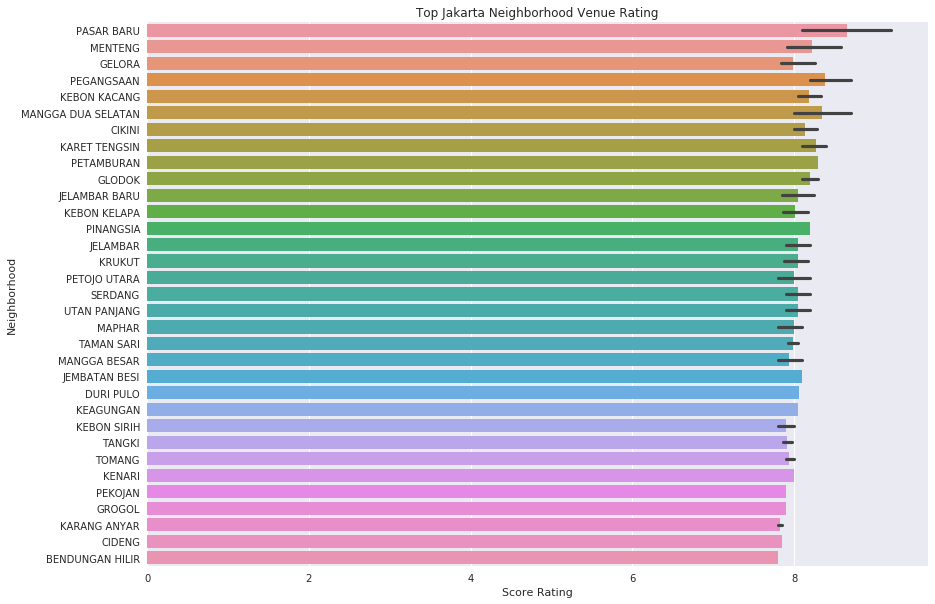

In [197]:
sns.set(rc={'figure.figsize':(14,10)})
axis = sns.barplot(data = top_100_venue_score.reset_index(), x = 'Venue Score', y = 'Neighborhood')
axis.set_title("Top Jakarta Neighborhood Venue Rating")
axis.set_xlabel('Score Rating')
plt.show()

In [145]:
# Print Jakarta Venue Dataframe Group By Top Score 
Jakarta_top_venue_score=jakarta_venue_filter2.groupby(['Neighborhood','Venue Category'])['Venue Score'].mean().sort_values(ascending=False)

# Save dataframe for future use
Jakarta_top_venue_score.to_csv('Jakarta_top_venue_score.csv')

# Save Jakarta dataframe for future use
file = "Jakarta_top_venue_score.csv"
link = "Storage:Jakarta_top_venue_scorecsv"
file_to_save(Jakarta_top_venue_score,file,link)

In [146]:
# Jakarta Venue Group By Neighborhood
jakarta_venue_filter2.groupby('Neighborhood').count()

,Unnamed: 0,Unnamed: 0.1,Neighborhood Latitude,Neighborhood Longitude,VenueID,Venue,Venue Latitude,Venue Longitude,Venue CatID,Venue Category,Venue Score
Neighborhood,,,,,,,,,,,
ANGKE,1,1,1,1,1,1,1,1,1,1,1
BENDUNGAN HILIR,13,13,13,13,13,13,13,13,13,13,13
BUNGUR,1,1,1,1,1,1,1,1,1,1,1
CEMPAKA BARU,1,1,1,1,1,1,1,1,1,1,1
CEMPAKA PUTIH BARAT,6,6,6,6,6,6,6,6,6,6,6
CEMPAKA PUTIH TIMUR,11,11,11,11,11,11,11,11,11,11,11
CIDENG,19,19,19,19,19,19,19,19,19,19,19
CIKINI,23,23,23,23,23,23,23,23,23,23,23
DURI PULO,20,20,20,20,20,20,20,20,20,20,20


In [147]:
# Print Unique Categories on Neighborhood
print('There are {} uniques categories.'.format(len(jakarta_venue_filter2['Venue Category'].unique())))

There are 41 uniques categories.


In [148]:
# Use one hot encoding
jakarta_onehot = pd.get_dummies(jakarta_venue_filter2[['Venue Category']], prefix="", prefix_sep="")
jakarta_onehot.head()

,Acehnese Restaurant,American Restaurant,Asian Restaurant,BBQ Joint,Bakery,Bed & Breakfast,Beer Garden,Betawinese Restaurant,Bistro,Café,...,Pizza Place,Restaurant,Salad Place,Seafood Restaurant,Snack Place,Soup Place,Steakhouse,Sushi Restaurant,Vietnamese Restaurant,Wine Bar
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [149]:
# Put neighborhood back on to dataframe
jakarta_onehot['Neighborhood'] = jakarta_venue_filter2['Neighborhood'] 

# Rearange neighborhood columns
fixed_columns = [jakarta_onehot.columns[-1]] + list(jakarta_onehot.columns[:-1])
jakarta_onehot = jakarta_onehot[fixed_columns]

jakarta_onehot.head()

,Neighborhood,Acehnese Restaurant,American Restaurant,Asian Restaurant,BBQ Joint,Bakery,Bed & Breakfast,Beer Garden,Betawinese Restaurant,Bistro,...,Pizza Place,Restaurant,Salad Place,Seafood Restaurant,Snack Place,Soup Place,Steakhouse,Sushi Restaurant,Vietnamese Restaurant,Wine Bar
5,GAMBIR,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,GAMBIR,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,GAMBIR,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,GAMBIR,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,GAMBIR,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [150]:
jakarta_grouped = jakarta_onehot.groupby('Neighborhood').mean().reset_index()
print(jakarta_grouped.shape)
jakarta_grouped.head()

(71, 42)


,Neighborhood,Acehnese Restaurant,American Restaurant,Asian Restaurant,BBQ Joint,Bakery,Bed & Breakfast,Beer Garden,Betawinese Restaurant,Bistro,...,Pizza Place,Restaurant,Salad Place,Seafood Restaurant,Snack Place,Soup Place,Steakhouse,Sushi Restaurant,Vietnamese Restaurant,Wine Bar
0,ANGKE,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,BENDUNGAN HILIR,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076923,...,0.153846,0.076923,0.0,0.0,0.076923,0.076923,0.000000,0.0,0.0,0.0
2,BUNGUR,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,CEMPAKA BARU,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
4,CEMPAKA PUTIH BARAT,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.166667,0.0,0.0,0.0


### Print each neighborhood along with the top 10 most common venues


In [151]:
num_top_venues = 10
for neigh in jakarta_grouped['Neighborhood']:
    print("----"+neigh+"----")
    temp = jakarta_grouped[jakarta_grouped['Neighborhood'] == neigh].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----ANGKE----
                       venue  freq
0                     Bakery   1.0
1        Acehnese Restaurant   0.0
2                Pizza Place   0.0
3  Indonesian Meatball Place   0.0
4      Indonesian Restaurant   0.0
5         Italian Restaurant   0.0
6        Japanese Restaurant   0.0
7          Korean Restaurant   0.0
8           Malay Restaurant   0.0
9  Middle Eastern Restaurant   0.0


----BENDUNGAN HILIR----
                   venue  freq
0  Indonesian Restaurant  0.31
1            Pizza Place  0.15
2    Acehnese Restaurant  0.08
3                 Bistro  0.08
4             Food Truck  0.08
5             Restaurant  0.08
6            Coffee Shop  0.08
7            Snack Place  0.08
8             Soup Place  0.08
9     Seafood Restaurant  0.00


----BUNGUR----
                       venue  freq
0                     Bakery   1.0
1        Acehnese Restaurant   0.0
2                Pizza Place   0.0
3  Indonesian Meatball Place   0.0
4      Indonesian Restaurant   0.0
5      

### Create the new dataframe and display the top 10 venues for each neighborhood.


In [152]:
def popular_venue(row, num_top_venues):
    row_cat = row.iloc[1:]
    row_cat_sorted = row_cat.sort_values(ascending=False)
    
    return row_cat_sorted.index.values[0:num_top_venues]

In [153]:
num_top_venues = 10
# First, Second and Third
indicators = ['st', 'nd', 'rd'] 

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neigh_venues_sorted = pd.DataFrame(columns=columns)
neigh_venues_sorted['Neighborhood'] = jakarta_grouped['Neighborhood']

for ind in np.arange(jakarta_grouped.shape[0]):
    neigh_venues_sorted.iloc[ind, 1:] = popular_venue(jakarta_grouped.iloc[ind, :], num_top_venues)

In [154]:
neigh_venues_sorted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 11 columns):
Neighborhood              71 non-null object
1st Most Common Venue     71 non-null object
2nd Most Common Venue     71 non-null object
3rd Most Common Venue     71 non-null object
4th Most Common Venue     71 non-null object
5th Most Common Venue     71 non-null object
6th Most Common Venue     71 non-null object
7th Most Common Venue     71 non-null object
8th Most Common Venue     71 non-null object
9th Most Common Venue     71 non-null object
10th Most Common Venue    71 non-null object
dtypes: object(11)
memory usage: 6.2+ KB


In [155]:
print(neigh_venues_sorted.shape)
neigh_venues_sorted.head()

(71, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ANGKE,Bakery,Wine Bar,Chinese Restaurant,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,Coffee Shop
1,BENDUNGAN HILIR,Indonesian Restaurant,Pizza Place,Acehnese Restaurant,Food Truck,Soup Place,Snack Place,Restaurant,Coffee Shop,Bistro,Café
2,BUNGUR,Bakery,Wine Bar,Chinese Restaurant,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,Coffee Shop
3,CEMPAKA BARU,Coffee Shop,Wine Bar,Food Truck,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,Chinese Restaurant
4,CEMPAKA PUTIH BARAT,Indonesian Restaurant,Café,Steakhouse,Indonesian Meatball Place,Bistro,Chinese Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop


In [156]:
neigh_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ANGKE,Bakery,Wine Bar,Chinese Restaurant,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,Coffee Shop
1,BENDUNGAN HILIR,Indonesian Restaurant,Pizza Place,Acehnese Restaurant,Food Truck,Soup Place,Snack Place,Restaurant,Coffee Shop,Bistro,Café
2,BUNGUR,Bakery,Wine Bar,Chinese Restaurant,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,Coffee Shop
3,CEMPAKA BARU,Coffee Shop,Wine Bar,Food Truck,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,Chinese Restaurant
4,CEMPAKA PUTIH BARAT,Indonesian Restaurant,Café,Steakhouse,Indonesian Meatball Place,Bistro,Chinese Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop
5,CEMPAKA PUTIH TIMUR,Fast Food Restaurant,Asian Restaurant,Restaurant,Indonesian Restaurant,Coffee Shop,Café,Food Court,Noodle House,Fried Chicken Joint,Betawinese Restaurant
6,CIDENG,Noodle House,Indonesian Restaurant,Food Truck,Soup Place,Pizza Place,Donut Shop,Café,Seafood Restaurant,Bakery,Restaurant
7,CIKINI,Indonesian Restaurant,Café,Bakery,Coffee Shop,Noodle House,Betawinese Restaurant,Japanese Restaurant,Middle Eastern Restaurant,Asian Restaurant,Dessert Shop
8,DURI PULO,Soup Place,Indonesian Restaurant,Café,Food Truck,Pizza Place,Noodle House,Chinese Restaurant,Donut Shop,Indian Restaurant,Restaurant
9,DURI SELATAN,Bakery,Wine Bar,Chinese Restaurant,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,Coffee Shop


### Cluster Neighborhoods

Run k-means to cluster the neighborhood into clusters.

In [157]:
# Import Sklearn cluster
from sklearn.cluster import KMeans

# Import plot libraries
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors

#### Find out optimal K with knee method

In [158]:
# Prepare dataframe for Machine Learning. 
# Remove Neighborhood Column
jakarta_grouped_clustering = jakarta_grouped.drop('Neighborhood', 1)

In [159]:
# Use Sum Square Distance Sum of Square Error
sse = []
idx = range(1, 15)
for k in idx:
    knn = KMeans(n_clusters=k)
    knn = knn.fit(jakarta_grouped_clustering)
    sse.append(knn.inertia_)

In [160]:
optimal_k= pd.DataFrame(data= sse, columns = ['Sum Square Error'], index = idx)
optimal_k.rename_axis('K Value', axis = 'columns', inplace = True)
#optimal_k

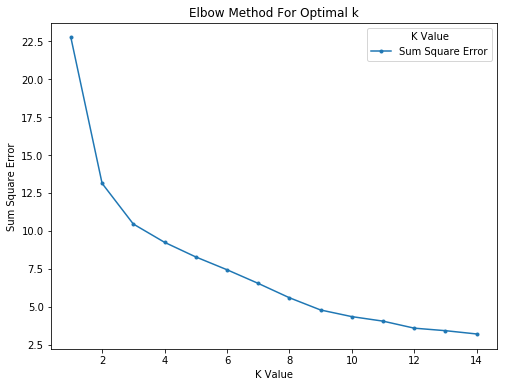

In [161]:
optimal_k.plot(kind = 'line', figsize = (8, 6), marker = '.')
plt.xlabel('K Value')
plt.ylabel('Sum Square Error')
plt.title('Elbow Method For Optimal k')
plt.show()

It seems that our best suitable K value is 4.

In [162]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(jakarta_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 0, 1, 2, 0, 3, 3, 3, 3, 1], dtype=int32)

### Now let's put our cluster labels in our neighborhoods_venues_sorted data frame

In [163]:
jakarta_merge1 = neigh_venues_sorted

In [164]:
jakarta_merge1.shape

(71, 11)

In [165]:
# add clustering labels
jakarta_merge1['Cluster Labels'] = kmeans.labels_

In [166]:
print(jakarta_merge1.shape)
jakarta_merge1.head()

(71, 12)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,ANGKE,Bakery,Wine Bar,Chinese Restaurant,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,Coffee Shop,1
1,BENDUNGAN HILIR,Indonesian Restaurant,Pizza Place,Acehnese Restaurant,Food Truck,Soup Place,Snack Place,Restaurant,Coffee Shop,Bistro,Café,0
2,BUNGUR,Bakery,Wine Bar,Chinese Restaurant,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,Coffee Shop,1
3,CEMPAKA BARU,Coffee Shop,Wine Bar,Food Truck,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,Chinese Restaurant,2
4,CEMPAKA PUTIH BARAT,Indonesian Restaurant,Café,Steakhouse,Indonesian Meatball Place,Bistro,Chinese Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,0


In [167]:
jakarta_fill_df=jakarta_df5.filter(['PostalCode','Latitude','Longitude','Subdistricts','Regency'], axis=1)

In [168]:
jakarta_merge2 = jakarta_fill_df.join(jakarta_merge1.set_index('Neighborhood'), on='Subdistricts')

In [169]:
jakarta_merge3= jakarta_merge2 

In [170]:
print(jakarta_merge3.shape)
jakarta_merge3.head()

(267, 16)


,PostalCode,Latitude,Longitude,Subdistricts,Regency,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,10110,-6.175811,106.826906,GAMBIR,JAKARTA PUSAT,Indonesian Restaurant,Fast Food Restaurant,Food Truck,Soup Place,Cupcake Shop,Coffee Shop,Noodle House,Japanese Restaurant,Wine Bar,Chinese Restaurant,0.0
1,10120,-6.162065,106.826741,KEBON KELAPA,JAKARTA PUSAT,Chinese Restaurant,Seafood Restaurant,Noodle House,Asian Restaurant,Indonesian Meatball Place,Beer Garden,Steakhouse,Snack Place,BBQ Joint,Dessert Shop,3.0
2,10130,-6.164882,106.818566,PETOJO UTARA,JAKARTA PUSAT,Noodle House,Donut Shop,Fast Food Restaurant,Restaurant,Asian Restaurant,Coffee Shop,Indonesian Restaurant,Japanese Restaurant,Chinese Restaurant,Bed & Breakfast,3.0
3,10140,-6.165196,106.810215,DURI PULO,JAKARTA PUSAT,Soup Place,Indonesian Restaurant,Café,Food Truck,Pizza Place,Noodle House,Chinese Restaurant,Donut Shop,Indian Restaurant,Restaurant,3.0
4,10150,-6.167405,106.812690,CIDENG,JAKARTA PUSAT,Noodle House,Indonesian Restaurant,Food Truck,Soup Place,Pizza Place,Donut Shop,Café,Seafood Restaurant,Bakery,Restaurant,3.0


In [171]:
jakarta_merge4=jakarta_merge3.dropna(how='any')

In [172]:
print(jakarta_merge4.shape)
jakarta_merge4.head()

(71, 16)


,PostalCode,Latitude,Longitude,Subdistricts,Regency,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,10110,-6.175811,106.826906,GAMBIR,JAKARTA PUSAT,Indonesian Restaurant,Fast Food Restaurant,Food Truck,Soup Place,Cupcake Shop,Coffee Shop,Noodle House,Japanese Restaurant,Wine Bar,Chinese Restaurant,0.0
1,10120,-6.162065,106.826741,KEBON KELAPA,JAKARTA PUSAT,Chinese Restaurant,Seafood Restaurant,Noodle House,Asian Restaurant,Indonesian Meatball Place,Beer Garden,Steakhouse,Snack Place,BBQ Joint,Dessert Shop,3.0
2,10130,-6.164882,106.818566,PETOJO UTARA,JAKARTA PUSAT,Noodle House,Donut Shop,Fast Food Restaurant,Restaurant,Asian Restaurant,Coffee Shop,Indonesian Restaurant,Japanese Restaurant,Chinese Restaurant,Bed & Breakfast,3.0
3,10140,-6.165196,106.810215,DURI PULO,JAKARTA PUSAT,Soup Place,Indonesian Restaurant,Café,Food Truck,Pizza Place,Noodle House,Chinese Restaurant,Donut Shop,Indian Restaurant,Restaurant,3.0
4,10150,-6.167405,106.812690,CIDENG,JAKARTA PUSAT,Noodle House,Indonesian Restaurant,Food Truck,Soup Place,Pizza Place,Donut Shop,Café,Seafood Restaurant,Bakery,Restaurant,3.0


In [173]:
jakarta_merge4['Cluster Labels'] = jakarta_merge4['Cluster Labels'].astype(int)

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [174]:
print(jakarta_merge4.shape)
jakarta_merge4.head()

(71, 16)


,PostalCode,Latitude,Longitude,Subdistricts,Regency,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,10110,-6.175811,106.826906,GAMBIR,JAKARTA PUSAT,Indonesian Restaurant,Fast Food Restaurant,Food Truck,Soup Place,Cupcake Shop,Coffee Shop,Noodle House,Japanese Restaurant,Wine Bar,Chinese Restaurant,0
1,10120,-6.162065,106.826741,KEBON KELAPA,JAKARTA PUSAT,Chinese Restaurant,Seafood Restaurant,Noodle House,Asian Restaurant,Indonesian Meatball Place,Beer Garden,Steakhouse,Snack Place,BBQ Joint,Dessert Shop,3
2,10130,-6.164882,106.818566,PETOJO UTARA,JAKARTA PUSAT,Noodle House,Donut Shop,Fast Food Restaurant,Restaurant,Asian Restaurant,Coffee Shop,Indonesian Restaurant,Japanese Restaurant,Chinese Restaurant,Bed & Breakfast,3
3,10140,-6.165196,106.810215,DURI PULO,JAKARTA PUSAT,Soup Place,Indonesian Restaurant,Café,Food Truck,Pizza Place,Noodle House,Chinese Restaurant,Donut Shop,Indian Restaurant,Restaurant,3
4,10150,-6.167405,106.812690,CIDENG,JAKARTA PUSAT,Noodle House,Indonesian Restaurant,Food Truck,Soup Place,Pizza Place,Donut Shop,Café,Seafood Restaurant,Bakery,Restaurant,3


### Visualized Neighborhood

In [175]:
# create map
map_clusters = folium.Map(location = [latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(jakarta_merge4['Latitude'],jakarta_merge4['Longitude'], jakarta_merge4['Subdistricts'],jakarta_merge4['Cluster Labels']):
    #print(rainbow[cluster-1])
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine each of the clusters

#### Cluster 1

In [176]:
jakarta_merge4.loc[jakarta_merge4['Cluster Labels'] == 0, jakarta_merge4.columns[[0] + list(range(3, jakarta_merge4.shape[1]))]]

,PostalCode,Subdistricts,Regency,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,10110,GAMBIR,JAKARTA PUSAT,Indonesian Restaurant,Fast Food Restaurant,Food Truck,Soup Place,Cupcake Shop,Coffee Shop,Noodle House,Japanese Restaurant,Wine Bar,Chinese Restaurant,0
6,10210,BENDUNGAN HILIR,JAKARTA PUSAT,Indonesian Restaurant,Pizza Place,Acehnese Restaurant,Food Truck,Soup Place,Snack Place,Restaurant,Coffee Shop,Bistro,Café,0
8,10230,KEBON MELATI,JAKARTA PUSAT,Soup Place,Indonesian Meatball Place,Indonesian Restaurant,Wine Bar,Chinese Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,0
10,10250,KAMPUNG BALI,JAKARTA PUSAT,Indonesian Restaurant,Café,Bed & Breakfast,Fast Food Restaurant,Food Truck,Betawinese Restaurant,Food Court,Asian Restaurant,Beer Garden,Bakery,0
11,10260,PETAMBURAN,JAKARTA PUSAT,Indonesian Restaurant,Middle Eastern Restaurant,Coffee Shop,Indonesian Meatball Place,Food Truck,Asian Restaurant,Bakery,Cupcake Shop,Dumpling Restaurant,Donut Shop,0
14,10320,PEGANGSAAN,JAKARTA PUSAT,Indonesian Restaurant,Food Truck,Coffee Shop,Café,Fast Food Restaurant,Donut Shop,Asian Restaurant,Snack Place,Vietnamese Restaurant,Restaurant,0
19,10420,KWITANG,JAKARTA PUSAT,Indonesian Restaurant,Noodle House,Fast Food Restaurant,Asian Restaurant,BBQ Joint,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,American Restaurant,Dessert Shop,0
22,10450,KRAMAT,JAKARTA PUSAT,Indonesian Restaurant,Noodle House,Donut Shop,Café,Dumpling Restaurant,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,Coffee Shop,Chinese Restaurant,0
25,10520,CEMPAKA PUTIH BARAT,JAKARTA PUSAT,Indonesian Restaurant,Café,Steakhouse,Indonesian Meatball Place,Bistro,Chinese Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,0
26,10530,GALUR,JAKARTA PUSAT,Indonesian Restaurant,Café,Steakhouse,Chinese Restaurant,Wine Bar,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,0


In [177]:
cluster1=jakarta_merge4.loc[jakarta_merge4['Cluster Labels'] == 0, jakarta_merge4.columns[[0] + list(range(3, jakarta_merge4.shape[1]))]]# Save Jakarta dataframe for future use

file = "Jakarta_cluster1.csv"
link = "Storage:Jakarta_cluster1_csv"
file_to_save(cluster1,file,link)

In [178]:
cluster1

,PostalCode,Subdistricts,Regency,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,10110,GAMBIR,JAKARTA PUSAT,Indonesian Restaurant,Fast Food Restaurant,Food Truck,Soup Place,Cupcake Shop,Coffee Shop,Noodle House,Japanese Restaurant,Wine Bar,Chinese Restaurant,0
6,10210,BENDUNGAN HILIR,JAKARTA PUSAT,Indonesian Restaurant,Pizza Place,Acehnese Restaurant,Food Truck,Soup Place,Snack Place,Restaurant,Coffee Shop,Bistro,Café,0
8,10230,KEBON MELATI,JAKARTA PUSAT,Soup Place,Indonesian Meatball Place,Indonesian Restaurant,Wine Bar,Chinese Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,0
10,10250,KAMPUNG BALI,JAKARTA PUSAT,Indonesian Restaurant,Café,Bed & Breakfast,Fast Food Restaurant,Food Truck,Betawinese Restaurant,Food Court,Asian Restaurant,Beer Garden,Bakery,0
11,10260,PETAMBURAN,JAKARTA PUSAT,Indonesian Restaurant,Middle Eastern Restaurant,Coffee Shop,Indonesian Meatball Place,Food Truck,Asian Restaurant,Bakery,Cupcake Shop,Dumpling Restaurant,Donut Shop,0
14,10320,PEGANGSAAN,JAKARTA PUSAT,Indonesian Restaurant,Food Truck,Coffee Shop,Café,Fast Food Restaurant,Donut Shop,Asian Restaurant,Snack Place,Vietnamese Restaurant,Restaurant,0
19,10420,KWITANG,JAKARTA PUSAT,Indonesian Restaurant,Noodle House,Fast Food Restaurant,Asian Restaurant,BBQ Joint,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,American Restaurant,Dessert Shop,0
22,10450,KRAMAT,JAKARTA PUSAT,Indonesian Restaurant,Noodle House,Donut Shop,Café,Dumpling Restaurant,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,Coffee Shop,Chinese Restaurant,0
25,10520,CEMPAKA PUTIH BARAT,JAKARTA PUSAT,Indonesian Restaurant,Café,Steakhouse,Indonesian Meatball Place,Bistro,Chinese Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,0
26,10530,GALUR,JAKARTA PUSAT,Indonesian Restaurant,Café,Steakhouse,Chinese Restaurant,Wine Bar,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,0


#### Cluster 2

In [179]:
cluster2=jakarta_merge4.loc[jakarta_merge4['Cluster Labels'] == 1, jakarta_merge4.columns[[0] + list(range(3, jakarta_merge4.shape[1]))]]# Save Jakarta dataframe for future use

file = "Jakarta_cluster2.csv"
link = "Storage:Jakarta_cluster2_csv"
file_to_save(cluster2,file,link)

In [180]:
cluster2

,PostalCode,Subdistricts,Regency,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
17,10350,GONDANGDIA,JAKARTA PUSAT,Bakery,Wine Bar,Chinese Restaurant,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,Coffee Shop,1
23,10460,BUNGUR,JAKARTA PUSAT,Bakery,Wine Bar,Chinese Restaurant,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,Coffee Shop,1
28,10550,KAMPUNG RAWA,JAKARTA PUSAT,Bakery,Wine Bar,Chinese Restaurant,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,Coffee Shop,1
52,11210,TANAH SEREAL,JAKARTA BARAT,Bakery,Wine Bar,Chinese Restaurant,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,Coffee Shop,1
53,11220,TAMBORA,JAKARTA BARAT,Bakery,Wine Bar,Chinese Restaurant,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,Coffee Shop,1
54,11230,ROA MALAKA,JAKARTA BARAT,Bakery,Wine Bar,Chinese Restaurant,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,Coffee Shop,1
58,11270,DURI SELATAN,JAKARTA BARAT,Bakery,Wine Bar,Chinese Restaurant,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,Coffee Shop,1
59,11270,DURI UTARA,JAKARTA BARAT,Bakery,Wine Bar,Chinese Restaurant,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,Coffee Shop,1
60,11310,KALI ANYAR,JAKARTA BARAT,Bakery,Wine Bar,Chinese Restaurant,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,Coffee Shop,1
62,11330,ANGKE,JAKARTA BARAT,Bakery,Wine Bar,Chinese Restaurant,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,Coffee Shop,1


#### Cluster 3

In [181]:
cluster3=jakarta_merge4.loc[jakarta_merge4['Cluster Labels'] == 2, jakarta_merge4.columns[[0] + list(range(3, jakarta_merge4.shape[1]))]]# Save Jakarta dataframe for future use

file = "Jakarta_cluster3.csv"
link = "Storage:Jakarta_cluster3_csv"
file_to_save(cluster3,file,link)

In [182]:
cluster3

,PostalCode,Subdistricts,Regency,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
34,10640,CEMPAKA BARU,JAKARTA PUSAT,Coffee Shop,Wine Bar,Food Truck,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,Chinese Restaurant,2
35,10640,HARAPAN MULYA,JAKARTA PUSAT,Coffee Shop,Wine Bar,Food Truck,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,Chinese Restaurant,2
36,10640,SUMUR BATU,JAKARTA PUSAT,Coffee Shop,Wine Bar,Food Truck,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,Chinese Restaurant,2


#### Cluster 4

In [183]:
cluster4=jakarta_merge4.loc[jakarta_merge4['Cluster Labels'] == 3, jakarta_merge4.columns[[0] + list(range(3, jakarta_merge4.shape[1]))]]# Save Jakarta dataframe for future use

file = "Jakarta_cluster4.csv"
link = "Storage:Jakarta_cluster4_csv"
file_to_save(cluster4,file,link)

In [184]:
cluster4

,PostalCode,Subdistricts,Regency,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
1,10120,KEBON KELAPA,JAKARTA PUSAT,Chinese Restaurant,Seafood Restaurant,Noodle House,Asian Restaurant,Indonesian Meatball Place,Beer Garden,Steakhouse,Snack Place,BBQ Joint,Dessert Shop,3
2,10130,PETOJO UTARA,JAKARTA PUSAT,Noodle House,Donut Shop,Fast Food Restaurant,Restaurant,Asian Restaurant,Coffee Shop,Indonesian Restaurant,Japanese Restaurant,Chinese Restaurant,Bed & Breakfast,3
3,10140,DURI PULO,JAKARTA PUSAT,Soup Place,Indonesian Restaurant,Café,Food Truck,Pizza Place,Noodle House,Chinese Restaurant,Donut Shop,Indian Restaurant,Restaurant,3
4,10150,CIDENG,JAKARTA PUSAT,Noodle House,Indonesian Restaurant,Food Truck,Soup Place,Pizza Place,Donut Shop,Café,Seafood Restaurant,Bakery,Restaurant,3
5,10160,PETOJO SELATAN,JAKARTA PUSAT,Indonesian Restaurant,Food Court,Food Truck,BBQ Joint,Restaurant,Noodle House,Coffee Shop,Chinese Restaurant,Dumpling Restaurant,Donut Shop,3
7,10220,KARET TENGSIN,JAKARTA PUSAT,Japanese Restaurant,Coffee Shop,Indonesian Restaurant,Asian Restaurant,Restaurant,Wine Bar,Sushi Restaurant,Café,Pizza Place,BBQ Joint,3
9,10240,KEBON KACANG,JAKARTA PUSAT,Coffee Shop,Chinese Restaurant,Japanese Restaurant,Restaurant,Asian Restaurant,Sushi Restaurant,Steakhouse,Café,Pizza Place,Dessert Shop,3
12,10270,GELORA,JAKARTA PUSAT,Café,Japanese Restaurant,Restaurant,Coffee Shop,Bakery,Indonesian Restaurant,Chinese Restaurant,Wine Bar,Sushi Restaurant,American Restaurant,3
13,10310,MENTENG,JAKARTA PUSAT,Coffee Shop,Steakhouse,Bakery,Restaurant,Indonesian Restaurant,Italian Restaurant,Fast Food Restaurant,Café,Chinese Restaurant,Wine Bar,3
15,10330,CIKINI,JAKARTA PUSAT,Indonesian Restaurant,Café,Bakery,Coffee Shop,Noodle House,Betawinese Restaurant,Japanese Restaurant,Middle Eastern Restaurant,Asian Restaurant,Dessert Shop,3


## Conclusion

Recommendation based on top 100 food venue in Jakarta has been presented above. Jakarta multi-cultural background population would be perfect for food lover who want to experience many kind of food. 

Jakarta neighborhood segmented to 4 cluster based on recommendation of machine learning algorithm. On cluster 1, Indonesian restaurant dominate top venue, bakery for cluster2, coffee shop for cluster 3, and chinese-japanese-noodle house-restaurant on cluster4. 

Top rating venue like Menteng Steakhouse and Gelora American Restaurant included in Cluster 4. These venue, received score 8.9 and up. 

I have collected around 35% top ranking food venue in Jakarta due to limitation of free version of Foursquare API. The result might significantly different from presented above when using full version.